In [1]:
from feature_utils.parallel import get_optimal_radial_basis_hypers_parallel, get_features_in_parallel
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.representations import SphericalInvariants as SOAP
from loader.loader import load_data

In [2]:
import joblib
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
frames_nos = {1:[],6:[],7:[],8:[]}
models = {1:[],6:[],7:[],8:[]}
hypers = {1:[],6:[],7:[],8:[]}

for specie in [1,6,7,8]:
    for model_no in range(16):
        models[specie].append(joblib.load(str(specie) + "_" + str(model_no) + "_name"))
        numpy_array_name = str(specie) + "_" + str(model_no) + ".npy"
        frames_nos[specie].append(np.load(numpy_array_name))
        with open(str(specie) + "_" + str(model_no) + "_hypers.json","r") as fg:
            hypers[specie].append(json.load(fg))
            

In [4]:
residuals_missing_five = {1:[],6:[],7:[],8:[]}
means_missing_five = {1:[],6:[],7:[],8:[]}
results_missing_five = {1:[],6:[],7:[],8:[]}
variances_missing_five = {1:[],6:[],7:[],8:[]}
true_vals_missing_five = {1:[],6:[],7:[],8:[]}


for specie in [1,6,7,8]:
    unique, counts = np.unique(frames_nos[specie],return_counts=True)
    missing_frames = unique[counts < 12]
    train_structures, test_structures, train_properties, test_properties = load_data("/home/kellner/packages/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                        "/home/kellner/packages/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=specie)
    frames_missing_five = []
    cs_iso_missing_five = []
    hypers_int = hypers[specie][0].copy()

    for frame in train_structures:
        if frame.info["NAME"] in missing_frames:
            frames_missing_five.append(frame)
            cs_iso_missing_five.append(frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]])

    true_vals_missing_five[specie] = np.concatenate(cs_iso_missing_five)        

    X_missing = get_features_in_parallel(frames_missing_five,calculator=SOAP,hypers=hypers_int)

    for model in models[specie]:
            results_missing_five[specie].append(model.predict(X_missing))

    mean_ensemble = np.mean(results_missing_five[specie],axis=0)
    std_ensemble = np.var(results_missing_five[specie],axis=0)
    residuals_ensemble = (mean_ensemble - true_vals_missing_five[specie]) ** 2
    residuals_missing_five[specie] = residuals_ensemble
    means_missing_five[specie] = mean_ensemble
    variances_missing_five[specie] = std_ensemble

FileNotFoundError: [Errno 2] No such file or directory: '/home/kellner/packages/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz'

In [6]:
frames_nos[1]

[array(['TISVEX', 'SUPVOO', 'XANHYD', ..., 'NOFBIT', 'EDAWIP', 'DTHDOM'],
       dtype='<U8'),
 array(['KICCOO11', 'WOCQEK', 'EVIXEM', ..., 'QENYOX', 'NIFDAI', 'QONRAN'],
       dtype='<U8'),
 array(['YOTSOR', 'QIWJAI', 'XIBSUX', ..., 'AYAHUE', 'AVAKAK', 'FOQKIF'],
       dtype='<U8'),
 array(['AJAPIL06', 'AJOFUA01', 'LIHXUW01', ..., 'OCASIV', 'CIKRET',
        'AHOMAM'], dtype='<U8'),
 array(['HESSIH', 'DIWPOO', 'THCHYD', ..., 'METHOL04', 'CERQOG', 'FIBWUI'],
       dtype='<U8'),
 array(['FOVYAQ01', 'XESRIW', 'XACSOL', ..., 'RIYZEF', 'YOVTUZ',
        'DIHIXL10'], dtype='<U8'),
 array(['MAPCIQ', 'HMHOCN02', 'TETZOL', ..., 'XIQCEF', 'KULMUA', 'VIWYAD'],
       dtype='<U8'),
 array(['WERHUX', 'KOMYEQ01', 'BOLLIY', ..., 'JAKCOO', 'KEPFAO', 'DEFYUI'],
       dtype='<U8'),
 array(['JOHJIB02', 'GAKXAT', 'GACSUB', ..., 'BEHBOG', 'HOFLAQ01',
        'MACTUH'], dtype='<U8'),
 array(['ITIPEG', 'FIKXAY', 'AJAPOR', ..., 'NOLDUP', 'WIKRAL', 'QQQFGS10'],
       dtype='<U8'),
 array(['ZUHKIW', 'BEHB

In [5]:
results = {1:[],6:[],7:[],8:[]}
results_test = {1:[],6:[],7:[],8:[]}
results_full_model_train = {1:None,6:None,7:None,8:None}
results_full_model_test = {1:None,6:None,7:None,8:None}

for specie in [1,6,7,8]:
    #load_structures
    #get_features
    train_structures, test_structures, train_properties, test_properties = load_data("/home/kellner/packages/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "/home/kellner/packages/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=specie)
    hypers_int = hypers[specie][0].copy()
    Xtrain = get_features_in_parallel(train_structures,calculator=SOAP,hypers=hypers_int)
    Xtest = get_features_in_parallel(test_structures,calculator=SOAP,hypers=hypers_int)
    
    for model in models[specie]:
        results[specie].append(model.predict(Xtrain))
        results_test[specie].append(model.predict(Xtest))
    
    
                      
                      
    full_model = joblib.load("/home/kellner/git_pack/ShiftML-Light/data/RR_this_work_models/{}_RR.joblib".format(specie))
    
    with open("/home/kellner/git_pack/ShiftML-Light/data/RR_this_work_models/hypers/{}_hypers.json".format(specie),"r") as fg:
        full_model_hypers = json.load(fg)                 
        
    Xtrain = get_features_in_parallel(train_structures,calculator=SOAP,hypers=full_model_hypers)
    Xtest = get_features_in_parallel(test_structures,calculator=SOAP,hypers=full_model_hypers)
    results_full_model_train[specie] = full_model.predict(Xtrain)
    results_full_model_test[specie] = full_model.predict(Xtest)
    
        
#get_prediction for each model


FileNotFoundError: [Errno 2] No such file or directory: '/home/kellner/packages/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz'

In [20]:
specie = 1

unique, counts = np.unique(frames_nos[specie],return_counts=True)
missing_frames = unique[counts < 12]


train_structures, test_structures, train_properties, test_properties = load_data("/home/kellner/packages/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                        "/home/kellner/packages/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=specie)

frames_missing_five = []
cs_iso_missing_five = []

for model in frames_nos[specie]:
    in_this_model = []
    for frame in train_structures:
            if frame.info["NAME"] in model:
                frames_missing_five.append(frame)
                tmp = frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]]
                cs_iso_missing_five.append(np.ones(len(tmp)))
            else:
                cs_iso_missing_five.append(np.zeros(frame.numbers[frame.numbers == specie].shape))

In [21]:


train_structures, test_structures, train_properties, test_properties = load_data("/home/kellner/packages/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                        "/home/kellner/packages/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=specie)

missing_in_models = []

for model in frames_nos[specie]:
    in_this_model = []
    for frame in train_structures:
            if frame.info["NAME"] in model:
                tmp = frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]]
                in_this_model.append(np.ones(len(tmp)))
            else:
                in_this_model.append(np.zeros(frame.numbers[frame.numbers == specie].shape))
    missing_in_models.append(np.concatenate(in_this_model))



In [8]:
true_vals = {1:None,6:None,7:None,8:None}
true_vals_test = {1:None,6:None,7:None,8:None}
for specie in [1,6,7,8]:
    #load_structures
    #get_features
    train_structures, test_structures, train_properties, test_properties = load_data("/home/kellner/packages/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "/home/kellner/packages/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=specie)
    true_vals[specie] = train_properties
    true_vals_test[specie] = test_properties

In [9]:
residuals = {1:None,6:None,7:None,8:None}
means = {1:None,6:None,7:None,8:None}
means_test = {1:None,6:None,7:None,8:None}
variances = {1:None,6:None,7:None,8:None}
variances_test = {1:None,6:None,7:None,8:None}

for specie in [1,6,7,8]:
    mean_ensemble = np.mean(results[specie],axis=0)
    mean_ensemble_test = np.mean(results_test[specie],axis=0)
    std_ensemble = np.var(results[specie],axis=0)
    std_ensemble_test = np.var(results_test[specie],axis=0)
    residuals_ensemble = (mean_ensemble - true_vals[specie]) ** 2
    residuals[specie] = residuals_ensemble
    means[specie] = mean_ensemble
    means_test[specie] = mean_ensemble_test
    variances[specie] = std_ensemble
    variances_test[specie] = std_ensemble_test
    

In [22]:
specie = 1
missing_total_encoded = np.array(missing_in_models).T
this_array = np.array(results[specie]).T

In [23]:
#np.save("17O_commitee_prediction.npy",this_array)
#np.save("17O_reference_shifts.npy",true_vals[specie])
np.save("1H_Binary_encoded_in_validation_set_1_else_0.npy",np.hstack(cs_iso_missing_five).astype("bool"))
#np.save("17O_test_commitee_prediction.npy",np.array(results_test[specie]).T)
#np.save("17O_test_reference_shifts.npy",true_vals_test[specie])
#np.save("17O_train_binary_1_hot_N_sample_M_models.npy",missing_total_encoded.astype("bool"))

In [73]:
 #results on train set

In [22]:
missing_total_encoded.shape

(134692, 16)

In [ ]:
np.save()

In [27]:
len(np.where( np.sum(missing_total_encoded,axis=1) < 12)[0])

48342

In [25]:
np.hstack(cs_iso_missing_five)

array([0., 0., 0., ..., 0., 0., 0.])

In [93]:
np.mean(this_array,axis=0)

array([25.2813955 , 25.2788571 , 25.27961791, 25.28275696, 25.28065451,
       25.28619397, 25.28372353, 25.28005433, 25.28331138, 25.27849981,
       25.28019985, 25.28003254, 25.28391754, 25.28330338, 25.28299485,
       25.27766242])

In [94]:
np.sqrt(np.mean((true_vals[1]-np.mean(this_array,axis=1))**2))

0.42389949464778054

In [96]:
type(true_vals[1])

numpy.ndarray

In [116]:
np.mean((np.mean(np.array(results_test[1]).T,axis=1)-true_vals_test[1])**2)
#true_vals_test[1].shape

0.4777233772507114

In [30]:
a

NameError: name 'a' is not defined

In [31]:
a = np.load("1H_commitee_prediction.npy")
b = np.load("1H_reference_shifts.npy")
c = np.load("Binary_encoded_in_validation_set_1_else_0.npy")

In [33]:
b.shape

(134692,)

In [118]:
e = np.load("1H_test_commitee_prediction.npy")
d = np.load("1H_test_reference_shifts.npy")

In [119]:
np.sqrt(np.mean((np.mean(e,axis=1)-d)**2))

0.4777233772507114

In [107]:
np.sqrt(np.mean((np.mean(a[c],axis=1)-b[c])**2))

0.4426103215247525

In [106]:
np.sqrt(np.mean((np.mean(a,axis=1)-b)**2))

0.42389949464778054

In [ ]:
this_array.astype()

In [81]:
np.array(results_missing_five[1]).T.shape

(48342, 16)

In [85]:
np.allclose(this_array[np.hstack(cs_iso_missing_five).astype("bool")],np.array(results_missing_five[1]).T)

True

In [59]:
this_array

array([[18.73134812, 18.90999823, 18.58416349, ..., 18.74548279,
        18.70981141, 18.72105241],
       [18.7313931 , 18.91003023, 18.58418768, ..., 18.74555485,
        18.70986495, 18.72111372],
       [18.73145542, 18.91010008, 18.58426679, ..., 18.74561593,
        18.70992597, 18.72116859],
       ...,
       [29.04300262, 29.07862575, 29.15674148, ..., 28.97005745,
        29.27737939, 29.06681523],
       [29.04304569, 29.0787119 , 29.15686516, ..., 28.97016377,
        29.27749159, 29.06692892],
       [29.0429963 , 29.07862433, 29.15673276, ..., 28.97004401,
        29.27737242, 29.06679726]])

In [16]:
specie = 6
off = 1#1.25
scaling_constant = np.sqrt(np.mean((residuals_missing_five[specie])/(variances_missing_five[specie])))


In [26]:
specie = 6
df_from_arr = pd.DataFrame({"true":true_vals_test[specie],"pred":means_test[specie],"error_ensemble":variances_test[specie],"error_pred":5.34 * variances_test[specie]})
df_from_arr["error_true"] = df_from_arr["true"]-df_from_arr["pred"]
df_from_arr["mses"] = (df_from_arr["true"]-df_from_arr["pred"])**2
df_from_arr["error_pred_1.25"] = df_from_arr["error_pred"] * 1.25

In [40]:

variance_validation_set = np.mean((np.sqrt(scaling_constant**2*variances_missing_five[specie])))
mse_validation_set = np.mean(residuals_missing_five[specie])

In [51]:
specie = 6
scaling_constant = np.sqrt(np.mean(residuals_missing_five[specie]/variances_missing_five[specie]))
mses_validation = np.mean(residuals_missing_five[specie])
uncertainty_estimation_validation = scaling_constant * np.sqrt(variances_missing_five[specie])
print(mses_validation)
print(np.mean(uncertainty_estimation_validation ** 2))

16.995909494171286
28.63411489633279


In [45]:
mses_validation

16.995909494171286

In [46]:
np.mean(uncertainty_estimation_validation ** 2)

28.63411489633279

In [ ]:
np.sqrt(variances_missing_five[specie]) 

In [31]:
variance_validation_set

4.333773719142595

In [32]:
mse_validation_set

16.995909494171286

In [33]:
np.sqrt(mse_validation_set)

4.122609549080689

In [18]:
from sklearn.metrics import mean_absolute_error

In [19]:
import matplotlib.pyplot as plt

In [32]:
np.sqrt(np.mean(df_from_arr["mses"]))

4.437857324092521

/home/kellner/anaconda3/envs/python38/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='error_true', ylabel='Density'>

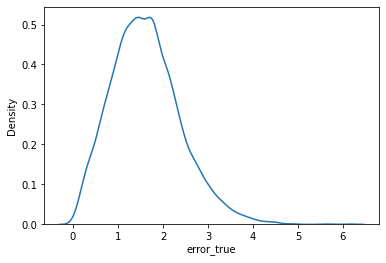

In [27]:
specie = 6
off = 1#1.25
scaling_constant = np.sqrt(np.mean((residuals_missing_five[specie])/(variances_missing_five[specie])))
df_from_arr = pd.DataFrame({"true":true_vals_test[specie],"pred":means_test[specie],"error_ensemble":variances_test[specie],"error_pred":5.34* variances_test[specie]})
df_from_arr["error_true"] = df_from_arr["true"]-df_from_arr["pred"]
df_from_arr["mses"] = (df_from_arr["true"]-df_from_arr["pred"])**2
df_from_arr["error_pred_1.25"] = df_from_arr["error_pred"] * 1.25

In [112]:
scaling_constant

3.16089393483604

In [113]:
np.mean(df_from_arr["error_pred"])

4.683237767141016

In [114]:
np.mean(df_from_arr["mses"])

19.694577629001632

In [115]:
np.sqrt(np.mean(df_from_arr["mses"]))

4.437857324092521

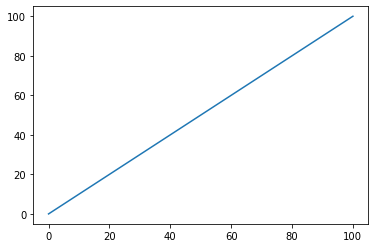

In [253]:
plt.plot(np.logspace(-2,2),np.logspace(-2,2))

Text(0, 0.5, 'Error [ppm]')

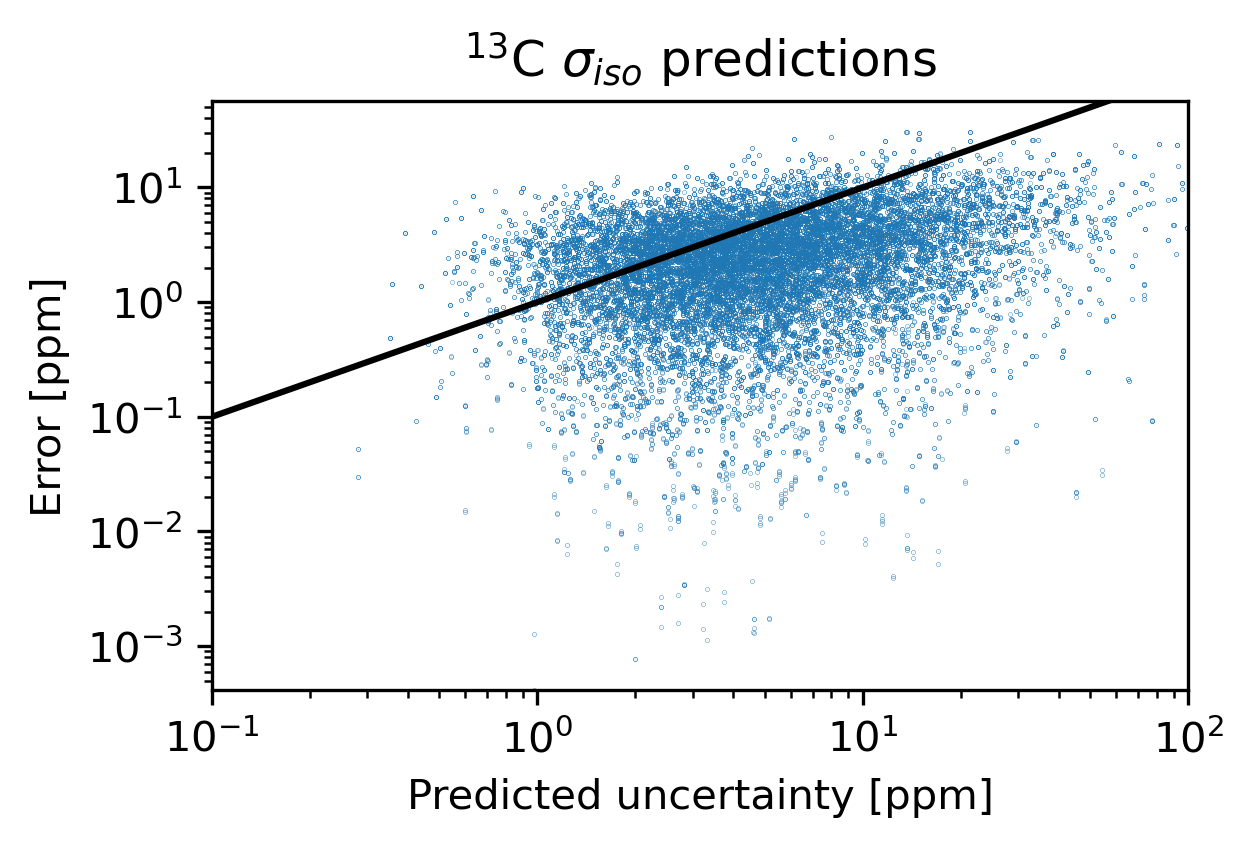

In [29]:
plt.figure(figsize=(4.2,2.6),dpi=300)
plt.title(r"$^{13}$C $\sigma_{iso}$ predictions")
plt.scatter(x=df_from_arr["error_pred"].to_numpy(),y=np.abs(df_from_arr["error_true"]), s=0.01)
#plt.scatter(x=rescaled_test_errors_quad,y=np.abs(df_from_arr["error_true"]), s=0.01)
plt.plot(np.logspace(-2,2),np.logspace(-2,2),c="black")
#plt.plot(a[::-1]**10,np.array(means_error_bins[::-1]))
#plt.plot(a[2:-1],np.array(means_error_bins)[2:-1],c="tab:red")
#plt.plot(np.logspace(-1,1,21),means_log_errs,c="tab:red")
#plt.plot(np.logspace(-1,1,21),np.array(means_log_errs)+np.array(stds_log_errs),c="tab:green")
plt.yscale("log")
plt.xscale("log")
plt.ylim(np.min(np.abs(df_from_arr["error_true"])),np.max(np.abs(df_from_arr["error_true"]))*1.5)
plt.xlim(0.1,100)
plt.xlabel("Predicted uncertainty [ppm]")
plt.ylabel("Error [ppm]")


In [319]:
def func(x,alpha,gamma):
    return alpha * x ** gamma

In [321]:
from scipy.optimize import curve_fit

In [322]:
popt, pcov = curve_fit(func, variances_missing_five[6], residuals_missing_five[6])

In [331]:
rescaled_test_errors_quad = np.array([func(i,11.10069791,0.64093106) for i in np.sqrt(df_from_arr["error_ensemble"].to_numpy())])

In [326]:
rescaled_test_errors_quad

array([ 4.2764579 ,  4.27665339,  4.27657759, ..., 24.03769097,
       24.04562753, 24.03791201])

(0.1, 100)

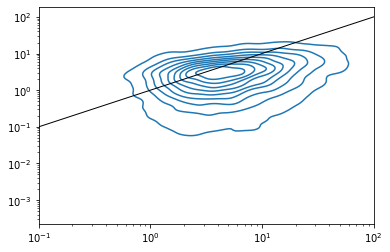

In [30]:
sns.kdeplot(x=df_from_arr["error_pred"].to_numpy(),y=np.abs(df_from_arr["error_true"].to_numpy()),log_scale=10)
plt.plot(np.logspace(-2,2),np.logspace(-2,2),c="black",linewidth=1)
plt.xlim(0.1,100)

In [312]:
a = np.log10(np.abs(df_from_arr["error_true"].to_numpy()))
d = np.abs(df_from_arr["error_true"].to_numpy())
b = np.digitize(a,np.linspace(-1,1,21,endpoint=False))
means_log_errs = []
stds_log_errs = []
for i in range(21):
    c = np.argwhere(b==i).flatten()
    means_log_errs.append(np.mean(d[c]))
    stds_log_errs.append(np.std(d[c]))

In [313]:
stds_log_errs

[0.0287205650873525,
 0.006931675029710716,
 0.00919868564250502,
 0.009836679447484935,
 0.013884603139302185,
 0.017421744778397075,
 0.019226030034077562,
 0.02591788318148404,
 0.03306715743490008,
 0.04175214755551739,
 0.05214417497729325,
 0.06355240026006524,
 0.0785760180871251,
 0.09563353479483033,
 0.11642338440376777,
 0.15144241763386374,
 0.19126683756800839,
 0.2430466945582856,
 0.2832259233474785,
 0.3706926850667857,
 0.44426199765171076]

In [310]:
means_log_errs

[0.052031085730704994,
 0.11292927684104509,
 0.14068947482791871,
 0.1743810455440743,
 0.21734282227710106,
 0.270992571089293,
 0.3342939664315606,
 0.41550528054138064,
 0.5195111799393491,
 0.6479376742034967,
 0.8103106738845173,
 1.009749556611585,
 1.2551451377383147,
 1.5544814112649576,
 1.9386768549188744,
 2.4081622260258215,
 3.0028591789243535,
 3.721714146042741,
 4.6439322488006995,
 5.745499497948144,
 7.192601432229702]

In [307]:
a

array([0.22466248, 0.22445427, 0.22465447, ..., 0.59241122, 0.5919204 ,
       0.59254843])

In [306]:
d

array([1.67749983, 1.67669577, 1.67746888, ..., 3.9121115 , 3.90769263,
       3.91334762])

In [301]:
len(np.linspace(-1,1,21))

21

In [297]:
np.where(b[0:100]==14)

(array([ 4,  5,  6,  7, 36, 37, 38, 39, 88, 89, 90, 91]),)

In [298]:
b[0:100]

array([13, 13, 13, 13, 14, 14, 14, 14, 17, 17, 17, 17, 16, 16, 16, 16, 18,
       18, 18, 18, 16, 16, 16, 16, 17, 17, 17, 17, 15, 15, 15, 15, 16, 16,
       16, 16, 14, 14, 14, 14, 18, 18, 18, 18, 13, 13, 13, 13,  5,  5,  5,
        5, 17, 17, 17, 17, 17, 17, 17, 17,  4,  4,  4,  4, 19, 19, 19, 19,
       12, 12, 12, 12, 18, 18, 18, 18, 16, 16, 16, 16, 18, 18, 18, 18, 12,
       12, 12, 12, 14, 14, 14, 14,  4,  4,  4,  4, 11, 11, 11, 11])

In [300]:
np.unique(b)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

(0.0, 10.0)

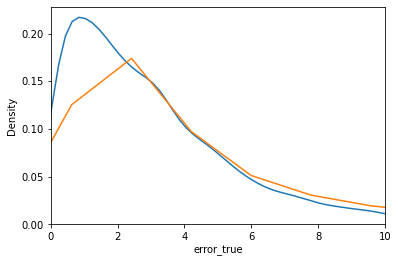

In [286]:
sns.kdeplot(np.abs(df_from_arr["error_true"]))
sns.kdeplot(np.abs(df_from_arr["error_pred"]))
plt.xlim(0,10)

In [282]:
stds_log_errs

array([0.02872057, 0.00756017, 0.00847266, 0.01123229, 0.01517883,
       0.01868227, 0.0231776 , 0.03029174, 0.03705464, 0.04656669,
       0.05746343, 0.07386778, 0.0951459 , 0.12233157, 0.14525051,
       0.18614437, 0.23509437, 0.29689302, 0.36937963, 0.46941504,
       0.5880903 ])

In [281]:
df_from_arr["error_true"]

0        1.677500
1        1.676696
2        1.677469
3        1.677493
4        2.251774
           ...   
31441    1.653298
31442   -3.908472
31443   -3.912111
31444   -3.907693
31445   -3.913348
Name: error_true, Length: 31446, dtype: float64

In [276]:
means_log_errs

array([0.05203109, 0.1142241 , 0.14297436, 0.17761522, 0.22584466,
       0.28317916, 0.35553305, 0.45036343, 0.5654974 , 0.71257288,
       0.8912758 , 1.12628918, 1.41886823, 1.79354023, 2.24810519,
       2.83760223, 3.53830601, 4.47698852, 5.59821291, 7.06639451,
       8.88920512])

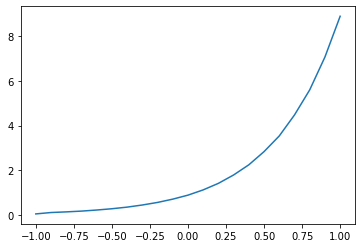

In [277]:
plt.plot(np.linspace(-1,1,21),means_log_errs)

In [260]:
means_log_errs

[-1.4090369508660299,
 -0.9464352854610627,
 -0.8426315863020764,
 -0.7517734901762905,
 -0.6494584831049809,
 -0.5456227785745308,
 -0.44986778916898035,
 -0.3466487777627792,
 -0.2490440478730433,
 -0.14798216726888835,
 -0.05028517680335102,
 0.0502377976887984,
 0.1501006933570399,
 0.2528290255395346,
 0.3498645493793238,
 0.45280266131100544,
 0.5474355230059655,
 0.6485887209489287,
 0.7475883286087132,
 0.8496925417784347,
 0.9474818412221985]

In [231]:
a**10

array([6.83908918e+04, 3.55900679e+04, 1.76940792e+04, 8.34666649e+03,
       3.70402090e+03, 1.52972134e+03, 5.79780052e+02, 1.97970063e+02,
       5.93863220e+01, 1.51036322e+01, 3.08997661e+00, 4.68242403e-01,
       4.56592939e-02, 2.18523253e-03, 2.71489463e-05, 9.06787753e-09,
       3.22394499e-15, 3.80385643e-07, 1.73019063e-04, 7.49677378e-03,
       1.15037474e-01, 9.80475216e-01, 5.71991479e+00, 2.56030462e+01,
       9.42398261e+01])

In [ ]:
plt.plot(a**10)

In [225]:
means_error_bins

[0.0007751400547739706,
 0.0011334815498358353,
 0.0016620694812328196,
 0.002929697719326718,
 0.003807447246526152,
 0.007003842801417725,
 0.01080147104853708,
 0.017156051713087622,
 0.02485559170676035,
 0.039959327325296196,
 0.062245719363444814,
 0.0963091588570941,
 0.1530796722470203,
 0.23936481323508285,
 0.3663336017776637,
 0.5688445890640997,
 0.8904583094324513,
 1.3836879815974723,
 2.1406619248466017,
 3.3025824153247756,
 5.068670004713538,
 7.851115470677519,
 11.922904033273293,
 18.150533440264827,
 34.21909847910593]

In [203]:
a**10

array([6.31208203e+06, 3.91637358e+06, 2.37248590e+06, 1.39969696e+06,
       8.01852608e+05, 4.44506048e+05, 2.37460871e+05, 1.21642830e+05,
       5.93945642e+04, 2.74379579e+04, 1.18814932e+04, 4.76614401e+03,
       1.74401508e+03, 5.70270702e+02, 1.61969838e+02, 3.83651417e+01,
       7.12762224e+00, 9.40821474e-01, 7.40564308e-02, 2.43047863e-03,
       1.30026347e-05, 1.16607629e-10, 7.03627342e-10, 2.36382634e-05,
       3.47866541e-03])

In [ ]:
np.abs

In [211]:

a = np.linspace(np.log10(np.min(np.abs(df_from_arr["error_true"])))*0.9,np.log10(np.max(np.abs(df_from_arr["error_true"]))),25)
b = np.log10(df_from_arr["error_true"].to_numpy())
c = np.digitize(b,a)

/tmp/ipykernel_45203/3491902054.py:2: RuntimeWarning: invalid value encountered in log10
  b = np.log10(df_from_arr["error_true"].to_numpy())


In [222]:
a ** 10

array([6.83908918e+04, 3.55900679e+04, 1.76940792e+04, 8.34666649e+03,
       3.70402090e+03, 1.52972134e+03, 5.79780052e+02, 1.97970063e+02,
       5.93863220e+01, 1.51036322e+01, 3.08997661e+00, 4.68242403e-01,
       4.56592939e-02, 2.18523253e-03, 2.71489463e-05, 9.06787753e-09,
       3.22394499e-15, 3.80385643e-07, 1.73019063e-04, 7.49677378e-03,
       1.15037474e-01, 9.80475216e-01, 5.71991479e+00, 2.56030462e+01,
       9.42398261e+01])

In [212]:
means_error_bins = []
for i in range(len(a)):
    means_error_bins.append(np.mean(np.abs(df_from_arr["error_true"].to_numpy())[np.argwhere(c == i).flatten()]))

In [213]:
means_error_bins

[0.0007751400547739706,
 0.0011334815498358353,
 0.0016620694812328196,
 0.002929697719326718,
 0.003807447246526152,
 0.007003842801417725,
 0.01080147104853708,
 0.017156051713087622,
 0.02485559170676035,
 0.039959327325296196,
 0.062245719363444814,
 0.0963091588570941,
 0.1530796722470203,
 0.23936481323508285,
 0.3663336017776637,
 0.5688445890640997,
 0.8904583094324513,
 1.3836879815974723,
 2.1406619248466017,
 3.3025824153247756,
 5.068670004713538,
 7.851115470677519,
 11.922904033273293,
 18.150533440264827,
 34.21909847910593]

In [184]:
np.min(df_from_arr["error_true"])

-30.564431331470505

In [182]:
np.log10(np.min(df_from_arr["error_true"]))

/tmp/ipykernel_45203/3032973550.py:1: RuntimeWarning: invalid value encountered in log10
  np.log10(np.min(df_from_arr["error_true"]))


nan

In [177]:
np.max(df_from_arr["error_true"])

37.62861938445632

In [128]:
a = np.digitize(df_from_arr["error_true"],np.logspace(np.min(df_from_arr["error_true"]),np.max(df_from_arr["error_true"])*1.1,100))

In [166]:
bins = np.linspace(np.min(df_from_arr["error_true"]),np.max(df_from_arr["error_true"]),50)
points_in_bin = np.digitize(np.log(df_from_arr["error_true"]),np.logspace(np.min(df_from_arr["error_true"]),np.max(df_from_arr["error_true"]),50))


/home/kellner/anaconda3/envs/python38/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [167]:
points_in_bin.shape

(31446,)

In [168]:
np.argwhere(points_in_bin == 40).flatten()

array([], dtype=int64)

In [169]:
means_error_bins = []
for i in range(len(bins)):
    means_error_bins.append(np.mean(df_from_arr["error_true"].to_numpy()[np.argwhere(points_in_bin == i).flatten()]))

In [170]:
means_error_bins

[0.48799292821569534,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0011173991689215,
 1.0263138785457195,
 1.9998160414064607,
 5.925780833122368,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

(-0.2, 10.0)

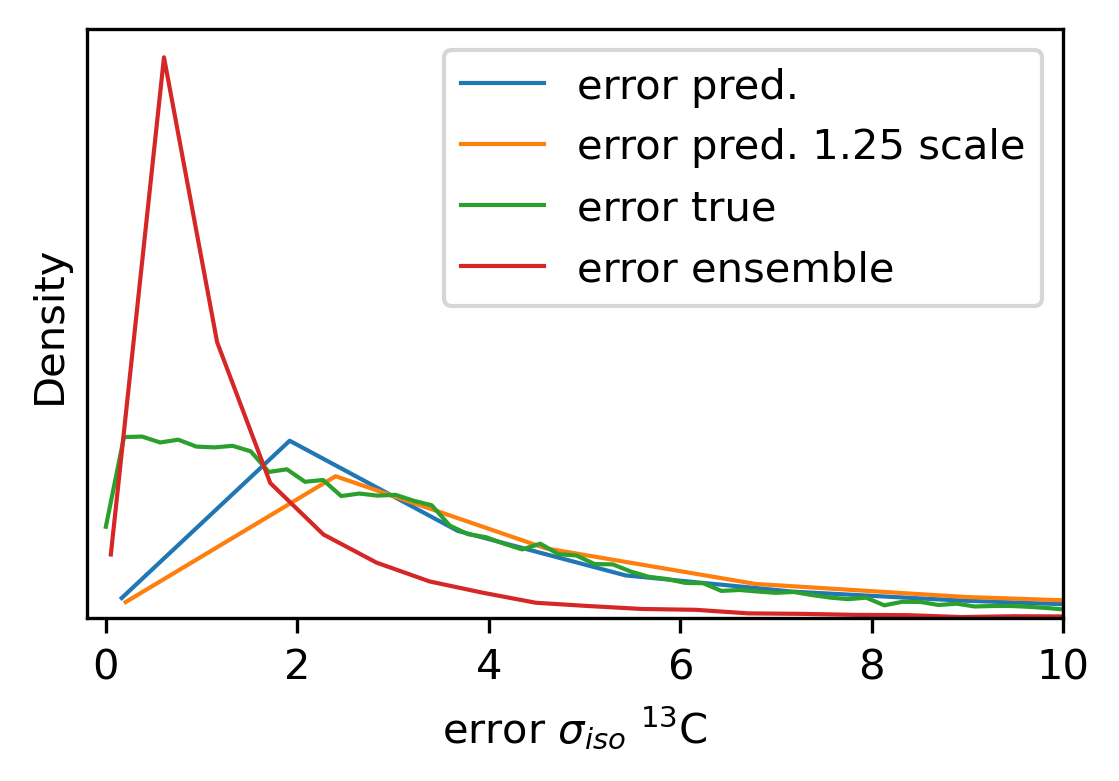

In [35]:
plt.figure(figsize=(4.2,2.6),dpi=300)
sns.kdeplot(data=df_from_arr["error_pred"],bw_adjust=0.25,linewidth=1,cut=0)
sns.kdeplot(data=df_from_arr["error_pred_1.25"],bw_adjust=0.25,linewidth=1,cut=0)
sns.kdeplot(np.sqrt(df_from_arr["mses"]),linewidth=1,bw_adjust=0.25,cut=0)
sns.kdeplot(data=df_from_arr["error_ensemble"],bw_adjust=0.25,linewidth=1,cut=0)
plt.yticks([])
plt.xlabel("error $\sigma_{iso}$ $^{13}$C")
#plt.axvline(mean_absolute_error(df_from_arr["true"],df_from_arr["pred"]),linestyle="--",c="black",linewidth=1,alpha=0.3,label="MAE")
plt.legend(["error pred.","error pred. 1.25 scale","error true","error ensemble"])#,"MAE"])
plt.xlim(-0.2,10)
#plt.savefig("predicted_errors.png",dpi=300,bbox_inches="tight")

3.9224029818806168

In [116]:
%pip install statsmodels

     |████████████████████████████████| 9.9 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 41.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [20]:
standard_dev_sample = {1:[],6:[],7:[],8:[]}
for specie in [1,6]:
    standard_dev_sample[key] = np.std(results_missing_five[specie],axis=0)

NameError: name 'key' is not defined

In [6]:
from scipy.stats import normaltest

In [7]:
my_data = norm.rvs(size=50000)
kstest(true_vals_missing_five[specie]-means_missing_five[specie],cdf="norm")

NameError: name 'norm' is not defined

In [ ]:
normaltest(true_vals_missing_five[specie]-means_missing_five[specie])

In [ ]:
normaltest(my_data)

In [119]:
help(norm)

Help on norm_gen in module scipy.stats._continuous_distns object:

class norm_gen(scipy.stats._distn_infrastructure.rv_continuous)
 |  norm_gen(momtype=1, a=None, b=None, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, extradoc=None, seed=None)
 |  
 |  A normal continuous random variable.
 |  
 |  The location (``loc``) keyword specifies the mean.
 |  The scale (``scale``) keyword specifies the standard deviation.
 |  
 |  %(before_notes)s
 |  
 |  Notes
 |  -----
 |  The probability density function for `norm` is:
 |  
 |  .. math::
 |  
 |      f(x) = \frac{\exp(-x^2/2)}{\sqrt{2\pi}}
 |  
 |  for a real number :math:`x`.
 |  
 |  %(after_notes)s
 |  
 |  %(example)s
 |  
 |  Method resolution order:
 |      norm_gen
 |      scipy.stats._distn_infrastructure.rv_continuous
 |      scipy.stats._distn_infrastructure.rv_generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit = wrapper(self, *args, **kwds)
 |      # if fit method is overridden only fo

In [ ]:
import matplotlib.mlab as mlab
from scipy.stats import norm


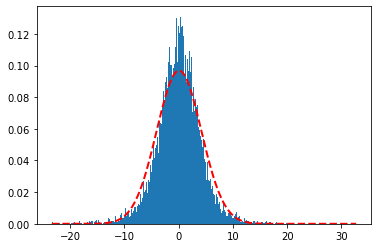

In [411]:
specie = 6
(mu, sigma) = norm.fit(true_vals_missing_five[specie]-means_missing_five[specie])
n, bins, patches = plt.hist(true_vals_missing_five[specie]-means_missing_five[specie],bins=300, density=True)
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

In [396]:
y = np.abs(norm.pdf( bins, mu, sigma))

In [417]:
variances_missing_five[specie]

array([1.48577408, 1.48555556, 1.48578102, ..., 0.2738913 , 0.60226606,
       0.60227828])

/tmp/ipykernel_21217/900897111.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(bins, y, 'r--', linewidth=1.5,color="tab:pink")


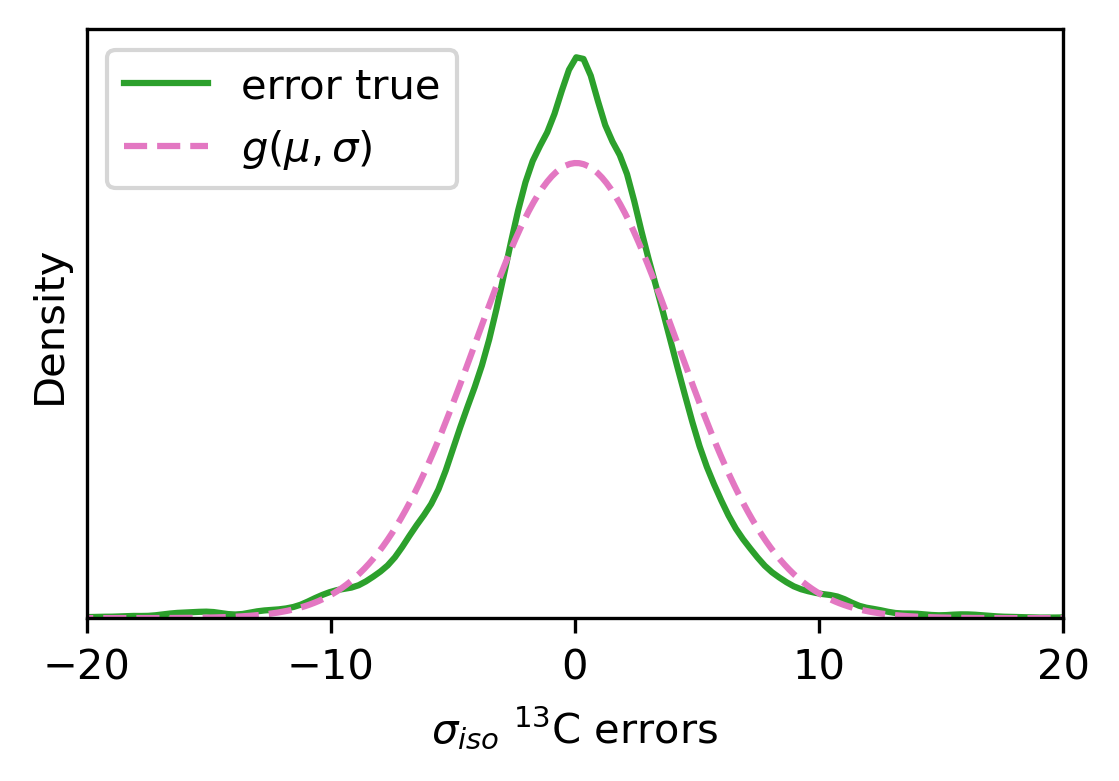

In [424]:
plt.figure(figsize=(4.2,2.6),dpi=300)
sns.kdeplot(true_vals_missing_five[specie]-means_missing_five[specie],color="tab:green")
#sns.kdeplot(variances_missing_five[specie])
plt.plot(bins, y, 'r--', linewidth=1.5,color="tab:pink")
plt.yticks([])
plt.xlabel("$\sigma_{iso}$ $^{13}$C errors")
plt.legend(["error true","$g(\mu,\sigma)$"],loc="upper left")
plt.xlim(-20.,20.)
plt.savefig("error_distributions.png",dpi=300,bbox_inches="tight")

### 

In [113]:
len(np.where(np.abs(means_test[specie]- true_vals_test[specie]) > variances_test[specie])[0])

29632

In [101]:
mean_ensemble_test[1]

40.48330422667083

In [ ]:
[]

In [289]:
np.array([2,4,8,16])/np.array([2,2,2,2])

array([1., 2., 4., 8.])

In [288]:
residuals_missing_five[specie]/variances_missing_five[specie]

array([6.31332800e+00, 7.38405700e+00, 6.24692768e+00, ...,
       1.28152135e+00, 9.76771601e-04, 9.03301638e-04])

In [350]:
def non_linear_var(x, alpha, gamma):
    return alpha**2 * x ** ((gamma/2)+1)

In [351]:
def linear_var(x, alpha):
    return alpha ** 2 * x

In [361]:
vf = np.vectorize(non_linear_var)

In [299]:
from scipy.optimize import curve_fit

In [346]:
np.sqrt(3.92)

1.9798989873223332

In [360]:
specie=1
curve_fit(non_linear_var,variances_missing_five[specie],residuals_missing_five[specie])

(array([ 1.64618309, -0.75117816]),
 array([[3.15264504e-05, 1.88742127e-05],
        [1.88742127e-05, 2.58822058e-05]]))

In [364]:
specie = 1
a = curve_fit(non_linear_var,variances_missing_five[specie],residuals_missing_five[specie])
alpha = a[0][0]
gamma = a[0][1]
off = 2
100 * len(np.where(np.abs(means_test[specie] -  true_vals_test[specie]) > off * vf(variances_test[specie],alpha,gamma))[0])/len(results_full_model_test[specie])

1.6464053954490068

In [321]:
len(results_full_model_test[specie])

35289

In [322]:
len(np.abs(means_test[specie]))

35289

In [37]:

specie = 6
off = 1
100 * len(np.where(np.abs(means_test[specie] -  true_vals_test[specie]) > off * vf(variances_test[specie],2.70993939,-0.75116956))[0])/len(results_full_model_test[specie])

NameError: name 'vf' is not defined

In [26]:
scaling_constant

3.020625035056037

In [171]:
means_test[specie]

array([40.48250017, 40.48330423, 40.48253112, ..., 31.2121115 ,
       31.20769263, 31.21334762])

In [18]:
import pandas as pd

In [19]:
variances_test

{1: array([0.0850934 , 0.08509327, 0.08509341, ..., 0.08197691, 0.0820419 ,
        0.08197515]),
 6: array([0.47514348, 0.47516042, 0.47515385, ..., 1.82709758, 1.82756818,
        1.82711069]),
 7: array([1.80336675, 1.80337632, 1.80333492, ..., 3.67897245, 3.67828846,
        3.67887489]),
 8: array([ 6.30139554,  6.29175041,  6.30133162, ..., 11.78970338,
         4.61034579,  4.61027082])}

In [38]:
ndf_from_arr["error_true"]

0       12.702017
1       13.243265
2       12.686519
3       13.240178
4       11.861573
          ...    
6341    80.940468
6342    79.901288
6343    79.890864
6344     2.630989
6345     2.630700
Name: error_true, Length: 6346, dtype: float64

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

(array([8.300e+01, 5.850e+02, 2.050e+03, 3.131e+03, 3.571e+03, 3.563e+03,
        3.077e+03, 2.801e+03, 2.414e+03, 1.852e+03, 1.453e+03, 1.333e+03,
        9.930e+02, 8.420e+02, 7.150e+02, 5.640e+02, 4.360e+02, 3.910e+02,
        2.700e+02, 2.090e+02, 2.110e+02, 1.620e+02, 1.020e+02, 8.700e+01,
        9.500e+01, 7.200e+01, 4.800e+01, 6.000e+01, 3.600e+01, 3.800e+01,
        2.000e+01, 8.000e+00, 2.000e+01, 1.800e+01, 1.800e+01, 4.000e+00,
        6.000e+00, 8.000e+00, 1.400e+01, 4.000e+00, 6.000e+00, 1.000e+01,
        8.000e+00, 0.000e+00, 2.000e+00, 6.000e+00, 4.000e+00, 8.000e+00,
        4.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 8.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 4.000e+0

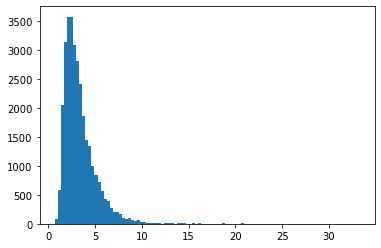

In [201]:
plt.hist(df_from_arr["error_pred"],bins=100)

Text(0.5, 0, 'True error $\\sigma_{iso}$ $^{13}$C')

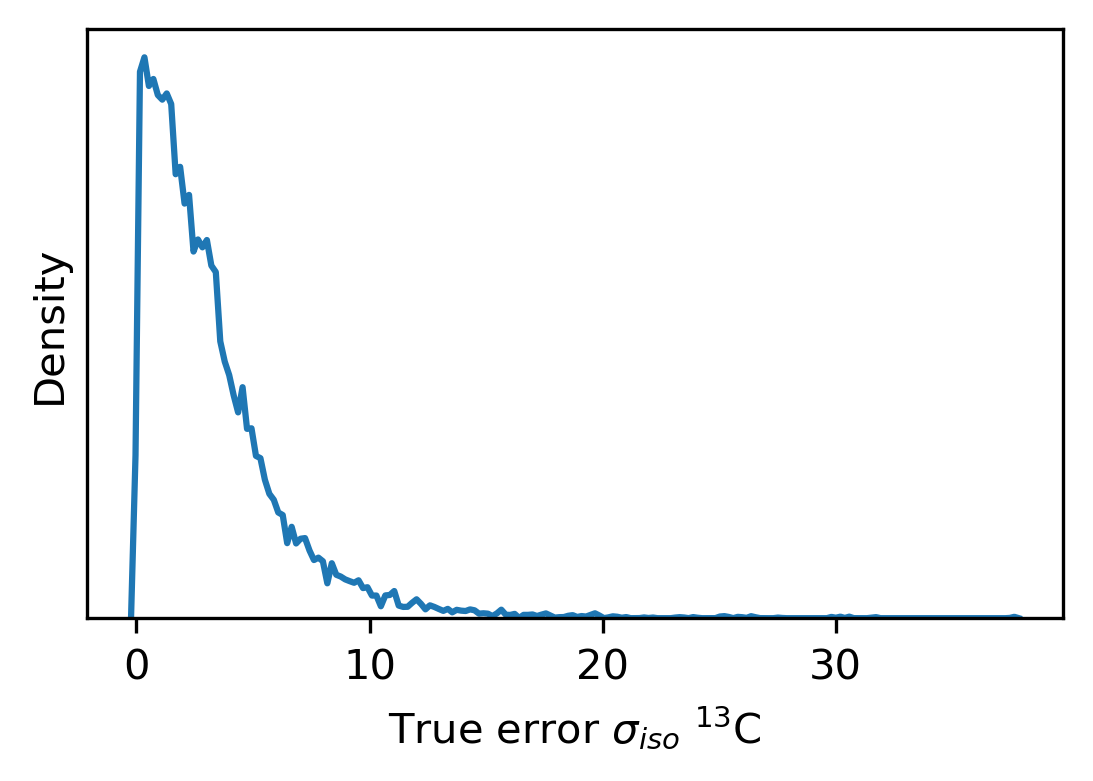

In [76]:
#sns.kdeplot(np.abs(df_from_arr["error_true"]-df_from_arr["error_pred"]),bw_adjust=0.2)
plt.figure(figsize=(4.2,2.6),dpi=300)
sns.kdeplot(df_from_arr["error_true"],bw_adjust=0.2)
plt.yticks([])
plt.xlabel("True error $\sigma_{iso}$ $^{13}$C")

#sns.kdeplot(df_from_arr["error_pred"],bw_adjust=0.2)
#plt.ylim(0.,0.05)

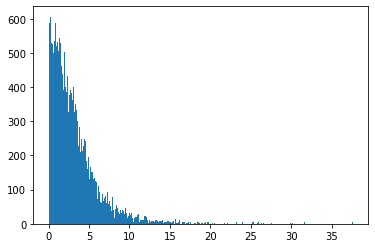

In [74]:
_ = plt.hist(df_from_arr["error_true"],bins=500)

In [72]:
np.min(df_from_arr["error_true"])

0.0004143315718678764

In [220]:
np.mean(df_from_arr["error_pred"]) + np.std(df_from_arr["error_pred"])

5.207647893558551

In [ ]:
plt.hist()

In [225]:
from scipy import stats

In [228]:
stats.mode(df_from_arr["error_true"].to_numpy())

ModeResult(mode=array([0.00041433]), count=array([1]))

(0.0, 1.0)

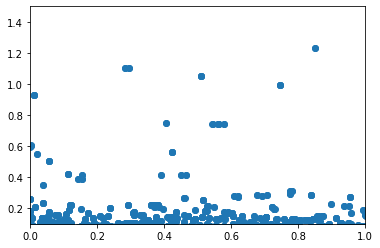

In [216]:
plt.scatter(residuals_missing_five[1],variances_missing_five[1])
plt.ylim(0.1,1.5)
plt.xlim(0.,1.)

In [217]:
df_from_arr.sample(n=100)

,true,pred,error_ensemble,error_pred,error_true,error_pred_1.25
3993,147.83,147.782653,0.489661,1.547767,0.047347,1.934709
1710,33.62,33.361864,0.944726,2.986178,0.258136,3.732723
29538,48.92,49.092936,0.827028,2.614148,0.172936,3.267685
7912,44.58,45.263608,0.840259,2.655971,0.683608,3.319964
28023,8.14,15.817166,1.299574,4.107814,7.677166,5.134768
...,...,...,...,...,...,...
7093,116.08,109.409460,1.315224,4.157283,6.670540,5.196604
19172,144.20,146.109718,0.940919,2.974145,1.909718,3.717682
7651,95.67,97.550412,0.891575,2.818173,1.880412,3.522717
28891,42.03,46.559787,0.863254,2.728655,4.529787,3.410819


In [67]:
np.concatenate(cs_iso_missing_five).shape

(48342,)

In [62]:
train_structures[0].arrays.keys()

dict_keys(['numbers', 'positions', 'cs_tensor', 'cs_iso', 'center_atoms_mask'])

In [57]:
"ACACOX0" in missing_frames

False

In [38]:
len(missing_frames)

1262

In [16]:
import matplotlib.pyplot as plt

(array([173., 473., 701., 766., 586., 426., 166.,  72.,  18.,   4.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

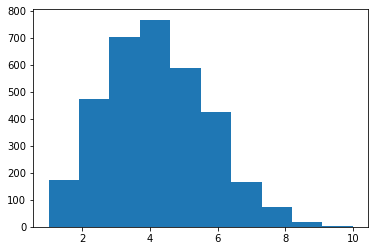

In [23]:
plt.hist(counts)

In [152]:
results

{1: [array([18.25564516, 18.25566587, 18.25570913, ..., 28.77483249,
         28.77490683, 28.77481128]),
  array([19.14980285, 19.14980862, 19.14985634, ..., 28.81894129,
         28.81896953, 28.81894636]),
  array([21.04140492, 21.04147525, 21.04151888, ..., 27.62447005,
         27.62456025, 27.62453767]),
  array([18.4427062 , 18.44270451, 18.44280145, ..., 28.17761312,
         28.17758774, 28.17766785]),
  array([20.31157012, 20.31164948, 20.31164244, ..., 28.62353937,
         28.62357146, 28.62353374]),
  array([18.50496545, 18.50503146, 18.50509133, ..., 28.87587246,
         28.87582467, 28.87590757]),
  array([18.53245791, 18.53251391, 18.53256329, ..., 28.90489412,
         28.90489997, 28.9049007 ]),
  array([20.65903609, 20.65909921, 20.65909889, ..., 28.7822045 ,
         28.78223192, 28.78221867]),
  array([18.51550112, 18.5155203 , 18.51555299, ..., 29.05024804,
         29.05034535, 29.05025126]),
  array([20.82438254, 20.82442953, 20.8244323 , ..., 28.13534697,
    

In [64]:
hypers[6][0]

{'soap_type': 'PowerSpectrum',
 'interaction_cutoff': 4.643475126818923,
 'max_radial': 8,
 'max_angular': 8,
 'gaussian_sigma_constant': 0.1793445885211041,
 'gaussian_sigma_type': 'Constant',
 'radial_basis': 'GTO',
 'normalize': True,
 'cutoff_smooth_width': 0.3,
 'cutoff_function_type': 'RadialScaling',
 'optimization': {'RadialDimReduction': {'projection_matrices': {'1': [[[0.013447514101351532,
       -0.01984351665904245,
       0.04716229361859538,
       -0.2232386835812527,
       -0.6922988028071397,
       -0.36398697256464135,
       -0.04939345273449808,
       -0.07571278609298386,
       -0.220011746927586,
       -0.21861805812391844,
       -0.1758692915589382,
       -0.17829035974866148,
       -0.17834736035170629,
       -0.20375743705239555,
       -0.16846086094599025,
       -0.17521983114321557,
       -0.14636373599437338,
       -0.10280261939108347,
       -0.05765160145040391,
       -0.02815104934313947],
      [-0.008209912497763719,
       0.01249447369

In [154]:
true_vals_test

{1: array([25.97, 25.97, 25.97, ..., 23.13, 23.13, 23.13]),
 6: array([42.16, 42.16, 42.16, ..., 27.3 , 27.3 , 27.3 ]),
 7: array([-94.55, -94.55, -94.55, ..., -62.84, -62.83, -62.84]),
 8: array([ 34.99,  34.92,  34.99, ..., 275.74, 270.72, 270.72])}

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

(array([2.8289e+04, 6.0920e+03, 7.0400e+02, 1.2400e+02, 5.0000e+01,
        6.0000e+00, 1.2000e+01, 8.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([0.02655705, 0.1121095 , 0.19766196, 0.28321442, 0.36876687,
        0.45431933, 0.53987179, 0.62542424, 0.7109767 , 0.79652916,
        0.88208161]),
 <BarContainer object of 10 artists>)

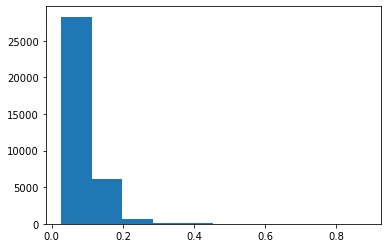

In [37]:
plt.hist(variances_test[1])

In [150]:
len(results_full_model_test[8])

6346

In [163]:
mean_squared_error(results_full_model_test[8],true_vals_test[8],squared=False)

17.38864529681493

In [46]:
mean_squared_error(results_full_model_test[1],true_vals_test[1],squared=False)

0.4832526271083852

In [50]:
len(means[1])

134692

In [53]:
mean_squared_error(means_test[6],true_vals_test[6],squared=False)

4.437857324092521

<AxesSubplot:ylabel='Density'>

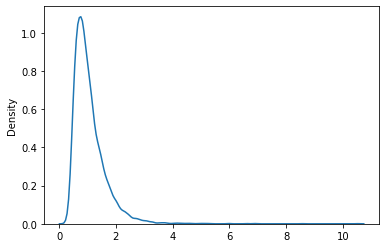

In [54]:
snf.kdeplot(variances_test[6])

In [36]:
specie = 6
len(np.where(np.abs(results_full_model_test[specie] -  true_vals_test[specie]) >  * variances_test[specie])[0])/len(results_full_model_test[specie])

SyntaxError: invalid syntax (125441118.py, line 2)

In [83]:
specie = 1 
scaling_constant = np.mean((residuals[specie])/(variances[specie] ** 2 ))

In [84]:
scaling_constant

1.2377295168943718

In [45]:
mean_absolute_error(means[6],true_vals[6])#,squared=False)

2.927452167894553

In [ ]:
mean

In [66]:
residuals[6]

array([2.57742717e+00, 2.57540521e+00, 2.57505087e+00, ...,
       5.47489958e+03, 5.47471785e+03, 5.47480522e+03])

In [65]:
means[6]

array([ 5.59543675,  5.59480691,  5.5946965 , ..., 60.16743562,
       60.16866367, 60.16807325])

In [ ]:
results

In [45]:
np.mean(results[1],axis=0).shape

(134692,)

In [47]:
np.std(results[1],axis=0) #.shape

array([1.05813718, 1.05815132, 1.058134  , ..., 0.40664411, 0.40666347,
       0.40662736])

In [91]:
results[1]

[array([18.25564516, 18.25566587, 18.25570913, ..., 28.77483249,
        28.77490683, 28.77481128]),
 array([19.14980285, 19.14980862, 19.14985634, ..., 28.81894129,
        28.81896953, 28.81894636]),
 array([21.04140492, 21.04147525, 21.04151888, ..., 27.62447005,
        27.62456025, 27.62453767]),
 array([18.4427062 , 18.44270451, 18.44280145, ..., 28.17761312,
        28.17758774, 28.17766785]),
 array([20.31157012, 20.31164948, 20.31164244, ..., 28.62353937,
        28.62357146, 28.62353374]),
 array([18.50496545, 18.50503146, 18.50509133, ..., 28.87587246,
        28.87582467, 28.87590757]),
 array([18.53245791, 18.53251391, 18.53256329, ..., 28.90489412,
        28.90489997, 28.9049007 ]),
 array([20.65903609, 20.65909921, 20.65909889, ..., 28.7822045 ,
        28.78223192, 28.78221867]),
 array([18.51550112, 18.5155203 , 18.51555299, ..., 29.05024804,
        29.05034535, 29.05025126]),
 array([20.82438254, 20.82442953, 20.8244323 , ..., 28.13534697,
        28.13526323, 28.13

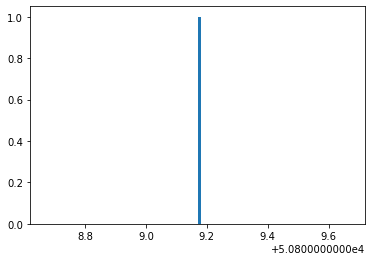

In [192]:
_ = plt.hist(np.std(residuals[8],axis=0),bins=100)

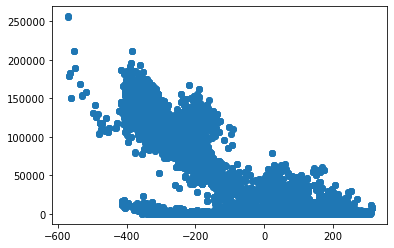

In [127]:
plt.scatter(true_vals[8],residuals[8])
#plt.xlim(0,10)

In [199]:
%pip install seaborn

     |████████████████████████████████| 292 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 25.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
import seaborn as snf

In [204]:
results[7]

[array([ 45.90075805,  45.90229704,  45.90054598, ..., -14.06948737,
        -14.08805275, -14.06874042]),
 array([ 58.51498816,  58.51719076,  58.51491636, ..., -16.81699752,
        -16.8267606 , -16.81794552]),
 array([  7.07526857,   7.07483188,   7.07406281, ..., -99.72683347,
        -99.7410259 , -99.72486016]),
 array([-563.9038006 , -563.90346865, -563.90418507, ..., -108.94820921,
        -108.97219927, -108.95250821]),
 array([ 44.15378502,  44.15260297,  44.15008567, ..., -29.07541965,
        -29.08519728, -29.07260672]),
 array([ 87.55303655,  87.55155199,  87.55114809, ..., -18.70305384,
        -18.70553302, -18.69639112]),
 array([101.72071934, 101.71909644, 101.7181569 , ..., -47.59662295,
        -47.60589726, -47.59461013]),
 array([ 57.59942452,  57.60080262,  57.59835938, ..., -91.99334107,
        -91.99717047, -91.99298006]),
 array([ 69.41878707,  69.41980107,  69.41831582, ..., -76.71970159,
        -76.7288271 , -76.71257916]),
 array([30.09404079, 30.0968310

In [12]:
for arr in results[7]:
    snf.kdeplot(x=arr)

KeyboardInterrupt: 

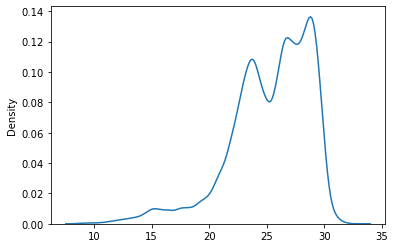

In [17]:
for arr in results[1]:
    snf.kdeplot(x=arr)

Text(0.5, 0, '$\\sigma_{iso}$ $^{1}$H')

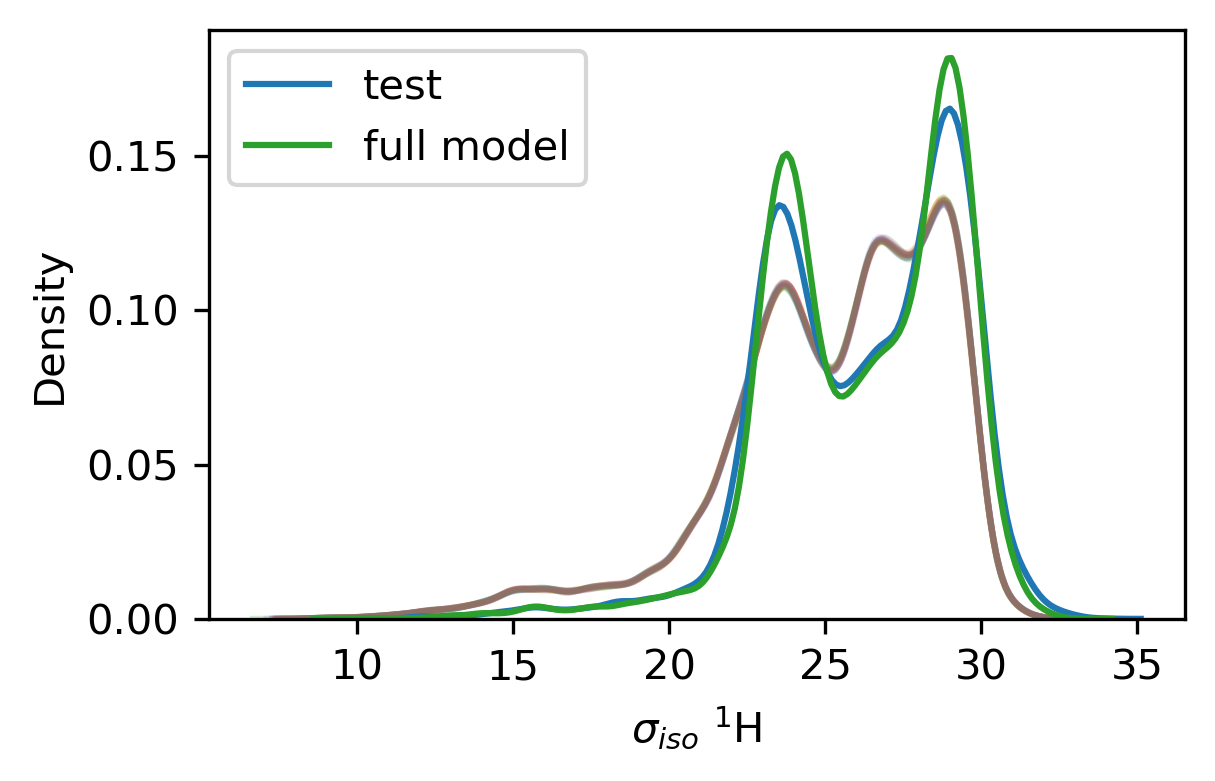

In [18]:
plt.figure(figsize=(4.2,2.6),dpi=300)
for arr in results[1]:
    snf.kdeplot(x=arr,alpha=0.2)
snf.kdeplot(true_vals_test[1],label="test",color="tab:blue")
snf.kdeplot(results_full_model_test[1],label="full model",color="tab:green")
plt.legend()
plt.xlabel("$\sigma_{iso}$ $^{1}$H")

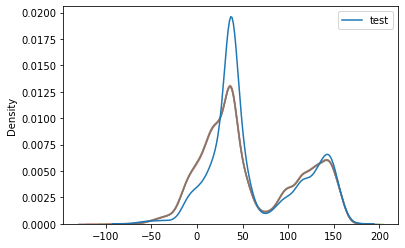

In [266]:
for arr in results[6]:
    snf.kdeplot(x=arr,alpha=0.2)
snf.kdeplot(true_vals_test[6],label="test",color="tab:blue")
plt.legend()

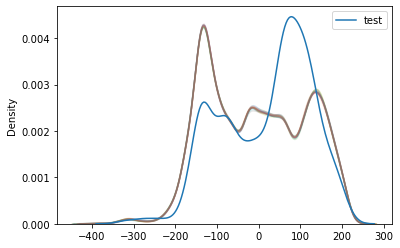

In [268]:
for arr in results[7]:
    snf.kdeplot(x=arr,alpha=0.2)
snf.kdeplot(true_vals_test[7],label="test",color="tab:blue")
plt.legend()

In [ ]:
for arr in results[7]:
    snf.kdeplot(x=arr,alpha=0.2)
snf.kdeplot(true_vals_test[6],label="test",color="tab:blue")
plt.legend()

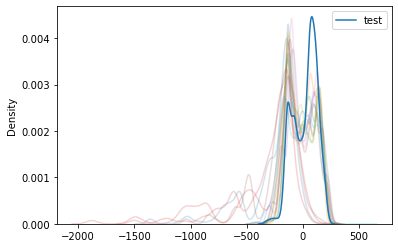

In [213]:
for arr in results[7]:
    snf.kdeplot(x=arr,alpha=0.2)
snf.kdeplot(true_vals_test[7],label="test",color="tab:blue")
plt.legend()
plt.

In [ ]:
for arr in results[1]:
    snf.kdeplot(x=arr)

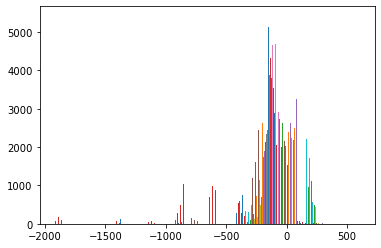

In [197]:
_ = plt.hist(results[7],bins=100)

In [194]:
results

{1: [array([18.25564516, 18.25566587, 18.25570913, ..., 28.77483249,
         28.77490683, 28.77481128]),
  array([19.14980285, 19.14980862, 19.14985634, ..., 28.81894129,
         28.81896953, 28.81894636]),
  array([21.04140492, 21.04147525, 21.04151888, ..., 27.62447005,
         27.62456025, 27.62453767]),
  array([18.4427062 , 18.44270451, 18.44280145, ..., 28.17761312,
         28.17758774, 28.17766785]),
  array([20.31157012, 20.31164948, 20.31164244, ..., 28.62353937,
         28.62357146, 28.62353374]),
  array([18.50496545, 18.50503146, 18.50509133, ..., 28.87587246,
         28.87582467, 28.87590757]),
  array([18.53245791, 18.53251391, 18.53256329, ..., 28.90489412,
         28.90489997, 28.9049007 ]),
  array([20.65903609, 20.65909921, 20.65909889, ..., 28.7822045 ,
         28.78223192, 28.78221867]),
  array([18.51550112, 18.5155203 , 18.51555299, ..., 29.05024804,
         29.05034535, 29.05025126]),
  array([20.82438254, 20.82442953, 20.8244323 , ..., 28.13534697,
    